![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">MATH - Final Project</a>


Although recommender systems are the secret source for many multi-billion businesses, prototyping a minimum viable recommender system takes only some basic mathematical and statistical fundamentals for machine learning to implement. For the final project, we will start from scratch and walk through the process of how to prototype a book recommender system.

* <a href="#99">Business Problem: Recommender System</a> (predict user preferences)
    * ML Problem and Data Loading
    
    
* <a href="#1">Question 1</a>: Basic Data Visualization
* <a href="#2">Question 2</a>: Data Vectorization
* <a href="#3">Question 3</a>: Model Definition
* <a href="#4">Question 4</a>: Baseline Model
* <a href="#5">Question 5</a>: Model Likelihood
* <a href="#6">Question 6</a>: Loss Function
* <a href="#7">Question 7</a>: Gradient Descent
* <a href="#8">Question 8</a>: Overfitting
* <a href="#9">Question 9</a>: Recommendations
* <a href="#10">Question 10</a>: Submit to Leaderboard


* <a href="#100">Final Comments</a> 

In [1]:
# Standard libraries
# Upgrade dependencies
#!pip install --upgrade pip
#!pip install --upgrade scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## <a name="99">Business Problem: Recommender System</a> 
(<a href="#0">Go to top</a>)

For your final project, you will leverage your growing mathematical knowledge to build a __recommender system__ similar to those that you find used throughout any digital content provider which will attempt to predict user's preferences based upon past ratings.  The technique we use is called a __model-based  collaborative filtering__ where we use only a user’s past behaviors (items previously purchased and ratings given to those items) to build a model to predict the missing data (ratings for items that the user may have an interest in).


#### Data Loading

We are using a subset of Amazon reviews for our task.  It is actually based after a [public dataset](http://jmcauley.ucsd.edu/data/amazon/) collected by scraping all reviews prior to 2014, extracting userID, ASIN, and star rating. This dataset itself would be very large and hard to train on owing to the fact there are many ASINs without only one or two reviews, and many users that only review one or two books.  The subset we use is actually a very restricted subset known as the $40$-core.  This is the collection of those ASINs and users such that every ASIN has at least 40 reviews and every user has reviewed at least 40 books (if you are wondering how this was done, see [this notebook](https://eider.corp.amazon.com/bwernes/notebook/output/NB90E71Y0N)). The ratings are on a scale from 1 to 5.

Let's load our datasets, ```training``` and ```test_features```. We build the recommender system using the ```training``` data, and evaluate how well the model performs on the ```test_features```, by submitting model predictions to this [leaderboard](https://leaderboard.corp.amazon.com/tasks/665).

The code below loads the datasets, stores a list of the unique userIDs and ASINs, counts the number of such userIDs and ASINs, and then splits the ```training``` dataset into two sets: ```train``` (train set) and ```val``` (validation set). We will use the validation set to evaluate model performance before submitting to the leaderboard.


In [2]:
# Import the datasets
training = pd.read_csv('../../notebooks/final_project/MATH_Final_Project_Data_training.csv', dtype = {'User': str, 'ASIN': str, 'Rating': np.int})
test_features = pd.read_csv('../../notebooks/final_project/MATH_Final_Project_Data_test_features.csv', dtype = {'User': str, 'ASIN': str})

print("-----------")
print("Sample Training Data")
print("-----------")
print(training.head(5))

print("-----------")
print("Sample Test Data")
print("-----------")
print(test_features.head(5))

# Count number of unique users and number of unique ASINs in our dataset
uniqueUsers = training['User'].unique().tolist()
uniqueASINs = training['ASIN'].unique().tolist()

# If using pandas.pivot(), beware that it sorts uniqueUsers and uniqueASINs by default
uniqueUsers.sort() # Sort, to avoid index matching errors later on
uniqueASINs.sort() # Sort, to avoid index matching errors later on

numUser = len(uniqueUsers)
numASIN = len(uniqueASINs)

print("-----------")
print("Number of Users: {}".format(numUser))
print("Number of ASINs: {}".format(numASIN))
print("-----------")


-----------
Sample Training Data
-----------
      ID            User        ASIN  Rating
0  66799  A3NDST1X8JVAP7  1490471103       5
1  80385  A1E2T8OSEMVN3H  149473592X       5
2  80636  A3BR1CG9CRXB6Z  1494755610       5
3  45627   AGYHA346U3CNP  1477694919       2
4  78045  A2N0YZV2JT6O72  1493752650       5
-----------
Sample Test Data
-----------
      ID            User        ASIN
0  84634  A1C7DFNSXTY09X  149617707X
1  55852  A13NJZ1M018A7C  1482594129
2  28875  A3RINEQ4GDTR55  144235948X
3  94134  A1W5758V90WQKZ  B008O0QUU2
4  31501  A243FA8XGHI63J  1455574880
-----------
Number of Users: 1490
Number of ASINs: 1186
-----------


In [3]:
from sklearn.model_selection import train_test_split

# Split to train and validation
train, val = train_test_split(training, random_state = 42, stratify = training['ASIN'])
num_train = train.shape[0]
num_val = val.shape[0]

print("Shape of Training Data", training.shape)
print("Shape of Test Features Data", test_features.shape)
print("Shape of Train Data", train.shape)
print("Shape of Validation Data", val.shape)

Shape of Training Data (81472, 4)
Shape of Test Features Data (27158, 3)
Shape of Train Data (61104, 4)
Shape of Validation Data (20368, 4)


##  <a name="1">1 Basic Data Visualization</a> 
(<a href="#0">Go to top</a>)

Let's dig in and start to do some data visualization.  When working with real-world data, it is always important to try to understand what bizarre little issues it has.  We've removed many of these for you, but all the same we should do at least a tiny exercise in data visualization so we can see some features of our data.

In a real world setting, data collected from feedbacks like user ratings can be very sparse and data points are mostly collected from very popular items (books) and highly engaged users. Large amount of less known items (books) don’t have ratings at all. Let’s see some plots on the distribution of books ratings frequency, to have a __better idea of the data we have__, and ponder whether is enough (and good enough) for a recommender model.


###  Project Question 1

> Use [MatPlotLib](https://matplotlib.org/) to make the following two plots: the [histogram](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) of the number of reviews a user gives, and a [scatter plot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html) of the average rating of an ASIN versus the number of ratings that ASIN received.  It is good pratice to not touch the testing data during model development, so make these plots only on the train data.

It is helpful to know you can use things like ```.groupby([fearure1][feature2].count())``` or ```.groupby([feature1][feature2].mean())``` to help with grabbing the data for the desired plots.

<AxesSubplot:>

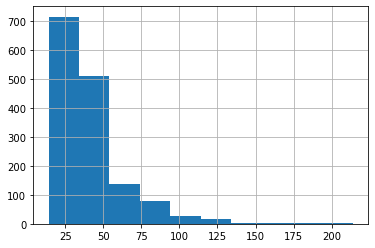

In [4]:
### Implement Code for Project Question 1 here
train.groupby(['User']).count()['Rating'].hist()

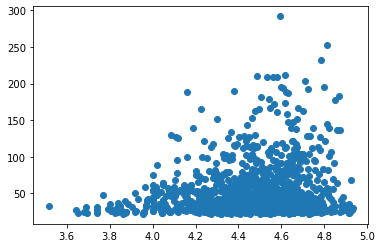

In [5]:
x = train.groupby(['ASIN']).mean()['Rating']
y = train.groupby(['ASIN']).count()['ID']

plt.scatter(x,y)
plt.show()

##  <a name="2">2 Data Vectorization</a> 
(<a href="#0">Go to top</a>)

Now that we agree we have enough (and good enough) data for a recommender system, we start thinking and planning to build a machine learning model to solve the problem. But, wait, if you go up and look again at the samples from our datasets we printed when we imported them, you'll notice the data it is not a vector or matrix exactly.  Various columns are strings rather than numbers, and even if we solved that (say by creating a unique ID number for every ASIN and user) it would still be in a very strange format.  __Deciding how to represent your data is a major first step in any ML problem, and in this case it is a bit subtle.__  

So, first, we need to transform the dataframe of ratings into a proper format that can be consumed by a machine learning model, with a recommender system in mind! We might, in fact, __want the data to be in an $n\times m$ matrix format__, where $n$ is the number of users and $m$ is the number of ASINs. 

We can thus think of our data as a score matrix $S = \left(s_{i,j}\right)$ which is a $n\times m$ matrix where
$$
s_{i,j} = \begin{cases}
s & \text{if the rating by user $i$ to ASIN $j$ was $s$ stars,}\\
0 & \text{otherwise,}
\end{cases}
$$
where $n$ is the number of users and $m$ is the number of ASINs.

As we might notice, our data is extremely sparse, that's to say with many zero elements. That makes sense, after examining the plots from Question 1. Our data is only partially observed, which is to say each user only rated a small number of ASINs. We will also need another matrix, the matrix of which ASINs were rated. 

Let $R = \left(r_{i,j}\right)$ be the matrix where
$$
r_{i,j} = \begin{cases}
1 & \text{if user $i$ rated ASIN $j$,}\\
0 & \text{otherwise.}
\end{cases}
$$
This matrix will allow us to mask off which entries were observed or not.

These matrices will form the core of the work we do in all future weeks, so it is a good idea to make them (create them, define them, put them together) now.


### Project Question 2
> Write code to translate our Pandas DataFrames into two numpy matrices.  You'll want to do it for both the train and validation data, so you will end up with four matrices ```R_train```, ```S_train```, ```R_val```, and ```S_val```. Print all four matrices and examine their elements - should be many values of zero!

It is helpful to know that other than defining the matrices with for loops or list comprehensions, you can also reshape the dataframes of ratings, by pivoting the dataframes to the desired format with users as rows and ASINs as columns.


In [6]:
s_train = train.pivot(index='User', columns='ASIN', values='Rating').to_numpy()
s_train[np.isnan(s_train)] = 0

s_val = val.pivot(index='User', columns='ASIN', values='Rating').to_numpy()
s_val[np.isnan(s_val)] = 0

print("Shape of s_train: ", s_train.shape)
print(s_train,'\n')
print("Shape of s_val", s_val.shape)
print(s_val)

Shape of s_train:  (1490, 1186)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 5. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Shape of s_val (1490, 1186)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
r_train = s_train.copy()
r_train[r_train > 0] = 1

r_val = s_val.copy()
r_val[r_val > 0] = 1

print("Shape of r_train: ", r_train.shape)
print(r_train,'\n')
print("Shape of r_val", r_val.shape)
print(r_val)

Shape of r_train:  (1490, 1186)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Shape of r_val (1490, 1186)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##  <a name="3">3 Model Definition</a> 
(<a href="#0">Go to top</a>)

To better understand how to approach thinking about and building a recommender system, at least by [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering#), it helps to print and examine the ```S_train```. You'll notice the zero entries. In order to define the model we will be working with, we need to have some way of making predictions  for the unfilled entries - that's the recommender system at the end of the day!  

Our goal with this project is to be able to construct a prediction matrix $P = (p_{i,j})$ which fills in all the missing scores where $r_{i,j} = 0$.  If we assumed nothing about how the matrix $P$ is constructed, we would have no basis to build a prediction.  We will need to assume P was generated from some process that has more structure than just an arbitrary matrix.

Let's ponder on two things. One, as we observed previously, the $S$ matrices have many zeros - that's good in a way, gives us the opportunity to build the recommender system in the first place. However, the matrices are huge, 1490
by 1186 (and they could be even bigger in other practical scenarios!). So, well, first we have this __high dimensions__ fact to handle - remember all the computational impediments related to storing, working, and manipulating large matrices even on current high-dimensionality friednly ML frameworks. Reducing dimensions can improve the performance of the algorithm in terms of both storage and time. We discussed matrix factorization as a simple way to build larger matrices from smaller ones - keep that thought for now!

Second, we have to start thinking about how are we going to find out how some users ratings or preferences of some ASINs might impact other unexplored users-ASINs preferences or ratings. We have to somehow find a way to connect users-ASINs-ratings in a meaningful way (well, __mathematically meaningful__ at least) to extract __underlying links__ that might exist between users-ASINs to explain their corresponding ratings, and leverage these __uncovered links__ to predict other users-ASINs interactions. Speaking of matrix factorization, or rather matrix multiplication, two matrices can be multiplied only if the number of columns in the first column is equal to the number of rows in the second matrix. Therefore the two reduced matrices have a common dimension, somehow hidden or covered dimension if you so wish, that we don't really see it in the final matrix product, but it had to be there in order to be able to compute the product to begin with. We thus turn to matrix factorization again - this is the solution to both our problems: reduce the dimensionality of our modeling approach, and actually building a relevant/appropriate model for a recommender system!

#### Matrix Factorization

Thus, we will make use of matrix multiplication to say that our prediction matrix should be the __product of two other matrices__. Basically, decomposing the users-ASINs interactions matrix into the product of two lower dimensionality rectangular matrices. These matrices actually represent the users and ASINs individually. The first matrix can be seen as the _users matrix_, where rows represent the users, and columns are telling us about some of users' affinities for ASINs - let's call it the *affinities* matrix $A$. The second matrix can be seen as the _ASINs matrix_, where rows tell us about the features ASINs have to offer to users, and columns represent the ASINs - let's call it the *features* matrix $F$. 

The columns in the users *affinities* matrix $A$ and the rows in the ASINs *features* matrix $F$ are called *latent factors* and are an indication of hidden characteristics about the users or the ASINs, patterns in the data that could lead to more personalized the recommendations. The number of such latent factors can be anything from one to hundreds. This number is one of the things that need to be optimized during the training of the model. 

The idea we will use is the following:  to each ASIN $j$ we will associate $k$ features $(f_{\ell,j})_{\ell = 1}^k$, and to each user $i$ we will associate $k$ affinities $(a_{i,\ell})_{\ell=1}^k$.  These features can be thought of as simple descriptors of the book, like for instance amount of action or romance.  The affinities, can be thought of as providing how much a person likes or dislikes a feature so perhaps $+1$ for action since they like action, and $-0.5$ for romance.

__The rating that a user will assign to a ASIN will be taken as a sum over all the features of their affinities for that feature times that ASIN's features.__

As a matter of useful terminology, in the world of ML, a *parameter* is a number that needs to be fixed in order to specify a model completely.  For instance, in this case every affinity and every feature must be specified for our model to be able to make predictions.  So if every user has two features, and every ASIN has two features, the total number of parameters is:
$$
\#\text{Parameters} = 2\cdot\#\text{User} + 2 \cdot\#\text{ASIN}.
$$

As a general rule of thumb, the more parameters you have, the more data you need to fit your model (an old statistics rule stated you need about 10 data points for each parameter).  There are exceptions to this (particularly in deep learning), but it is always a good idea to keep the number of parameters always in mind.


### Project Question 3
> Express the above verbally described model mathematically in matrix notation as a product of the matrices of features and affinities.  What are the dimensions of the matrices involved?  How many parameters are there in this model?  How does the number of parameters compare to the number of entries of $P$?

> Complete this question in abstract matrices shapes (in terms of $m,n,$ and $k$), and then say what this means for our dataset, in particular with $k=2$, in comparison to the total number of entries in $P$.  


############################################################################
### This is a Markdown cell - Type Answer for Project Question 3 here ###
############################################################################

Lets assume there are k features of books and hence there will k affinities of users to those features.

P = A . F

A is matrix of shape (n x k) and F is a matrix of shape (k x m) and P is a matrix of shape (n x m)

############################################################################


##  <a name="4">4 Baseline Model</a> 
(<a href="#0">Go to top</a>)

In your computation above, you should have seen that the total number of parameters is vastly smaller than the total number of entries in the matrix $P$.  This is a key component of the model: because we need to only find the value for a comparatively small number of parameters to specify all of $P$, we will force our model to hunt for structure in the observations rather than just memorize scores.

Let's consider a simple example of this type of model.  Set $k=1$.  Pick the single feature as the average star rating a book received, and everyone has affinity of $+1$ for that feature.  When you do the product of $P=AF$, note that this means that it predicts every single user gives the same rating to the ASIN, and that rating is the average value.  Throughout this document, we will refer to this as the __baseline model__.  It will give us a simple benchmark against which to measure our progress.

We will dive deeper into why with next questions, but it is reasonable to evaluate these predictions by computing the average squared difference between the predictions and the true values in the *test* set, where the test set can be any set we would like to test our model against (the train or the validation set, for example):

$$
{\frac{1}{\#\text{Test data points}}\sum_{\text{Test data}}(\text{prediction} - \text{true test observation})^2}
$$

This is called the mean squared error (or MSE for short). MSE has the same issue the variance has that we mentioned in class for the variance (that the units are uninterpretable), so traditionally we use the Root Mean Square (RMS) error which can be thought of how far our predictions are off on average and is obtained by taking the square root of the MSE:

$$
\sqrt{{\frac{1}{\#\text{Test data points}}\sum_{\text{Test data}}(\text{prediction} - \text{true test observation})^2}}.
$$


### Project Question 4
> Write code to compute the vector of average ASIN scores from the training set as our single feature.  Construct a vector of all ones ([np.ones](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ones.html) will do this for you) for your vector of affinities, and then use these two vectors to create a (baseline) matrix of predictions $P$. Print the matrix $P$ and examine its elements. How does it compare to the validation matrix $S$? Compute the MSE and the RMS on the validation set. How far off are we on average if we use this simple method for prediction?

For ease of implementation, note that RMS is the same as

$$
RMS = \frac{1}{\sqrt{\text{Test data points}}}\|R\circ(S-P)\|_2
$$

where we have use $R$ to mask off only the observed test entries, and the fact that the $L_2$ norm is nothing but the square root of the sum of the squares of entries. Using matrix products (implemented with ```np.dot(A, B)```, the Hadamard product (implemented with ```np.multiply(A, B)``` or ```A*B```), and ```np.linalg.norm```, computing this is a single line long.

In [8]:
### Implement Code for Project Question 4 here 
f = np.array(np.round(train.groupby(['ASIN']).mean()['Rating'],0))
a = np.ones((s_train.shape[0],1))
p = np.round(np.multiply(a,f),0)
print(p.shape)
error = (np.multiply(r_val, (s_val - p)))
mse_baseline = np.square(np.linalg.norm(error)) * (1/val.shape[0])
mse_baseline

(1490, 1186)


0.7322761194029851

In [9]:
### Implement Code for Project Question 4 here 
f = np.ones((s_train.shape[1],1))
a = np.array(np.round(train.groupby(['User']).mean()['Rating'],0))
p = np.round(np.multiply(a.T,f),0).T
print(p.shape)
error = (np.multiply(r_val, (s_val - p)))
mse_baseline = np.square(np.linalg.norm(error)) * (1/val.shape[0])
mse_baseline

(1490, 1186)


0.5337784760408484

##  <a name="5">5 Model Likelihood</a> 
(<a href="#0">Go to top</a>)


#### Propose a model to capture the underlying relationship in the dataset  

Our next investigations will be entirely theoretical and will contain no coding. We need to see how to bring randomness into the model that we defined.  The model we proposed so far was completely deterministic, we basically gave that our predictions are given by the product $P=AF$.  There was no allowance for error, and we need to fix that.

We originally specified that we wanted our scores to be obtained as $AF$.  Unless the universe follows our model exactly (that there are truly just $k$ numbers that determine how much a person likes a book and the person assigns that score every single time without fail) we will not have that $S = AF$.  Instead, we will have that $S$ looks like $P=AF$ plus some __independent random noise__, where that random noise is designed to capture all the inaccuracies in our model (that there are many features that determine how much a person will like a book, and that there can be random fluctuation in the rating given depending on things unrelated to the book at all).

We will do this by saying that $S \sim P + \mathcal{N}(0,\sigma^2)$ where we choose to model our noise as independent additive Gaussian noise.  The way to read this is that every rating we observed $s_{i,j}$ is distributed as a our prediction $p_{i,j}$ plus independent mean zero Gaussian noise of unknown variance for every observation.  Since adding a constant to a Gaussian just shifts the mean, we could also say that $s_{i,j}\sim\mathcal{N}(p_{i,j},\sigma^2)$.  The scale of the noise, $\sigma^2$, is now an additional parameter of our model.


#### Compute the likelihood that this model generates the data

For many __independent observations__, as we assume our ratings are, each with its own Gaussian probability densities as proposed above, the probability to observe all datapoints (all ratings) at the same time is computed by multiplying the individual probabilities together. We can thus compute the probability densities of our observations.  As a matter of terminology, the probability or probability density of obtaining a particular set of data is often called the __likelihood__.


### Project Question 5 
> Let $N$ be the total number of observed ratings (of the training dataset).  For our model, explain why the likelihood is:

$$ 
\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N e^{-\frac{1}{2\sigma^2}\sum_{N}(s_{i,j} - p_{i,j})^2}. 
$$

> Please write the derivation below.

It helps to know that ```\prod_{}``` in markdown is used to write down product of many things, just like ```\sum_{}``` in markdown is used to write the sum of many things. Also useful to remember one property of the exponential function: $e^a e^b = e^{a+b}$.

############################################################################
### This is a Markdown cell - Type Answer for Project Question 5 here ###
############################################################################

We established above that all the observations follow the gausian distribution with mean = pij and sd = sigma. Hence the likelihood or probability of observing a datapoint in a test is always equal to the above formula because we are taking product of independent probabilities.

############################################################################


##  <a name="6">6 Loss Function</a> 
(<a href="#0">Go to top</a>)


#### Compute the negative log-likelihood (loss function)

The key to the whole maximum likelihood estimation process is that we want to find out what values of the model parameters make the data most likely (occur with the highest probability).  Notice that many of the terms above in the likelihood we computed are unrelated to the dataset, such as the term in front of the exponential.  Thus if we want to find the choice of predictions $p_{i,j}$ that maximizes the probability, or the likelihood rather, and we don't care about the value of $\sigma^2$, we can throw away almost everything above.


### Project Question 6
> Explain that if you discard all terms that do not involve our data, the $-\log$-likelihood (the __loss function__) is essentially:

$$
\sum_{N}(s_{i,j} - p_{i,j})^2.
$$

> Then explain why minimizing this is the same thing as minimizing the MSE error, and thus we see that the intuitively reasonable MSE error is the same thing as maximizing the probability of our data.

It helps to remember some of the logarithms properties: $\log(ab) = \log(a) + \log(b)$, $\log(a^N) = N \log(a)$, and $\log(e) = 1$. However, the question can be answered even without using negative log, ust need to notice that $e^{-x}$ is a decreasing function.

############################################################################
### This is a Markdown cell - Type Answer for Project Question 6 here ###
############################################################################

taking log of the above probability density function will result in the mentioned formula. 
Also log(a.b) = loga + logb

############################################################################


##  <a name="7">7 Gradient Descent</a> 
(<a href="#0">Go to top</a>)


#### Find the model that minimizes the loss function

We will use a __gradient descent__ implementation to get this done, and consequently __learn the model from the train data__.

Note that while we often talked about minimizing the RMS (root mean squared error) because it was more interpretable, we can just as freely optimize the MSE since the square root would just make the math harder.  This freedom is useful: we can think about RMS if we want to interpret what we see, and we can think about the MSE if we want to computationally optimize the model.

Now, before diving into a computation let's take a moment and make sure our goals are clear.  We saw that it was reasonable to make our predictions using the product $AF$, since it corresponded to the idea that users have various preferences for various features of each ASIN.  If this was not a ML problem, we'd go through and assign to every ASIN a list of features by hand (perhaps using Mechanical Turk), and then hand code rules like, "if a person has assigned 5 stars to at least 10 sci-fi books, then they have affinity $+1$ for sci-fi books."  This would likely work, but there is a lot of trial and error, and human labor.

The ML solution is to essentially work this problem backwards.  We suppose that such features exist, we define a way to evaluate how well a collection of features and affinities works to describe the scores we observe, and then we try to automatically find the best possible set of features and affinities to explain the data we've seen.  Thus, our goal is to find the best possible values for $A$ and $F$ in the sense that they minimize the MSE.

We can now finally fully dive in to the implementation of gradient descent for our recommender dataset. Let's summarize what we have so far on our mean squared error loss function that can be written as

$$
L(A,F) = \frac{1}{N}\|R\circ(S-AF)\|_2^2,
$$

where the variables have the following meanings:
* $N$ is the number of data points in the dataset used to define $R$ or $S$.  Depending on the reason we are computing this, we could be dealing with either the training or testing data.
* $k$, while not contained in the above formula, is the number of features describing each ASIN.
* $R$ is the matrix that masks off those entries for which we have a score.
* $S$ is the matrix of observed scores.
* $A$ are the affinities of the users for various features.
* $F$ are the values of those features for all the ASINs.
* $AF$ is the matrix product that gives us our predictions for every pair of user and ASIN.

To perform our gradient descent, we must first compute the gradient of our mean square errors loss function with respect to the parameters of our model: the entries of $A$ and $F$. While this loss function is still simple enough so we can work with this mathematically to find its derivatives, here we discuss how to approach this with autograd for automate computing the gradients!


#### Implementing Gradient Descent with autograd

In order to implement gradient descent to solve our problem we need to define a few things:
* How do we initialize $A$ and $F$?
* What will we take for the number of features/affinities ($k$)?
* What will be our learning rate?
* When will we stop our optimization?

To find the best, we would want to do some *hyperparameter tuning*, which is to say optimization of the choices we make before running our optimization algorithms.  The accelerator classes discuss this at lenght, so we'll just take some values that work fairly well:
* Initialize $A$ and $F$ with random real values in the interval $[0,1]$ (```np.random.rand``` will be useful).  
* Take the number of features $k=2$. 
* Take the learning rate to be $25.0$
* Stop after $300$ steps.


### Project Question 7
> Implement the gradient descent algorithm. To monitor learning of your model, plot the MSE error on both the train and validation data as a function of the number of iterations.  How does the final validation loss compare with the value you got using the baseline model from Question 4? 


In [10]:
import numpy as np
import random
np.random.seed(42)

def loss_af(R, S, a,f, N, l1,l2):
    p = np.dot(a,f)
    delta = S - p
    se = np.linalg.norm(np.multiply(R, delta))
    return (np.square(se)  + (l1*np.square(np.linalg.norm(a))) + (l2*np.square(np.linalg.norm(f))))* (1/N)

def grad_a(r_train, s_train, a,f,N,l1):
    return (np.dot(np.multiply(r_train, (s_train - np.dot(a,f))), f.T)  - (2*l1*a)) * (2/N)

def grad_f(r_train, s_train, a,f,N,l2):
    return (np.dot(a.T, np.multiply(r_train, (s_train - np.dot(a,f)))) - (2*l2*f)) * (2/N)

k = 1
l1 = 0.007
l2 = 0.002
eta_a = 5
eta_f = 100
epochs = 300

params = {'k': k,
          'l1': l1,
          'l2': l2,
          'eta_a': eta_a,
          'eta_f': eta_f,
          'epochs': epochs
         }

f = np.random.normal(0,1,size=(k,s_train.shape[1]))
a = np.random.normal(0,1,size=(s_train.shape[0],k))
print("Shape of the P matrix", np.dot(a,f).shape)

N_train = train.shape[0]
N_val = val.shape[0]

training_loss = [loss_af(r_train, s_train, a,f, N_train,l1,l2)]
validation_loss = [loss_af(r_val, s_val, a, f, N_val,l1,l2)]


for epoch in range(epochs):
    f = f + eta_f*grad_f(r_train, s_train, a,f,N_train, l2) 
    a = a + eta_a*grad_a(r_train, s_train, a,f, N_train, l1)
    
    train_loss = loss_af(r_train, s_train, a,f, N_train,l1,l2)
    val_loss = loss_af(r_val, s_val, a, f, N_val,l1,l2)
    
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

print(train_loss, val_loss)

Shape of the P matrix (1490, 1186)
0.39941493932273053 0.42691527387694245


In [11]:
np.dot(a,f)

array([[3.99814885, 4.11294325, 4.14791559, ..., 3.99808028, 3.97315388,
        4.21030513],
       [4.4077984 , 4.53435462, 4.57291021, ..., 4.40772281, 4.38024245,
        4.64169218],
       [4.9185649 , 5.05978619, 5.10280952, ..., 4.91848055, 4.88781582,
        5.1795618 ],
       ...,
       [3.65690881, 3.76190558, 3.79389304, ..., 3.6568461 , 3.63404715,
        3.85095767],
       [4.86640143, 5.00612501, 5.04869206, ..., 4.86631798, 4.83597847,
        5.12463035],
       [4.14711596, 4.26618749, 4.30246286, ..., 4.14704484, 4.1211897 ,
        4.36717698]])

In [12]:
s_training = training.pivot(index='User', columns='ASIN', values='Rating').to_numpy()
s_training[np.isnan(s_training)] = 0
r_training = s_training.copy()
r_training[r_training > 0] = 1

In [13]:
k = 1
l1 = 0.007
l2 = 0.002
eta_a = 5
eta_f = 100
epochs = 300

f = np.random.normal(0,1,size=(k,s_train.shape[1]))
a = np.random.normal(0,1,size=(s_train.shape[0],k))
print("Shape of the P matrix", np.dot(a,f).shape)
N_train = training.shape[0]

training_loss = []
training_loss.append(loss_af(r_training, s_training, a,f, N_train,l1,l2))

for epoch in range(epochs):
    f = f + eta_f*grad_f(r_training, s_training, a,f,N_train, l2) 
    a = a + eta_a*grad_a(r_training, s_training, a,f, N_train, l1)
    
    train_loss = loss_af(r_training, s_training, a,f, N_train,l1,l2)
    
    training_loss.append(train_loss)
        
print(train_loss)

Shape of the P matrix (1490, 1186)
0.4010522475873088


In [14]:
P = np.dot(a,f)
np.unique(P)

array([1.70115376, 1.75043839, 1.78421909, ..., 5.87671434, 5.89620442,
       5.93596512])

In [15]:
P[P > 5] = 5
P[P < 1] = 1

In [ ]:
# ### Implement Code for Project Question 7 here 
# import numpy as numpy
# from mxnet import autograd, np, npx
# from mxnet.random import seed
# import random

# npx.set_np()

# f = np.random.normal(0,1,size=(3,s_train.shape[1]))
# a = np.random.normal(0,1,size=(s_train.shape[0],3))

# print("Shape of the P matrix", np.dot(a,f).shape)

# r_train_mxnet = np.array(r_train)
# s_train_mxnet = np.array(s_train)

# def loss_af(R, S, params, N):
#     a, f = params[0], params[1]
#     P = np.dot(a,f)
#     delta = S - P
#     mse = np.linalg.norm(np.multiply(R, delta))
#     return (mse**2)/ N

# params = [a, f]
# for param in params:
#     param.attach_grad()

# print(loss_af(r_train_mxnet, s_train_mxnet, params, train.shape[0]))

# out_a = [params[0]]
# out_f = [params[1]]

# eta = 0.1
# epochs = 300
# training_loss = []

# for epoch in range(epochs):
#     with autograd.record():
#         loss = loss_af(r_train_mxnet, s_train_mxnet, params, train.shape[0])
#     loss.backward()
#     training_loss.append(loss)
#     for param in params:
#         param[:] = param - eta * param.grad
#     out_a.append(params[0])
#     out_f.append(params[1])


##  <a name="8">8 Overfitting</a> 
(<a href="#0">Go to top</a>)

If all goes well over the training period, the training and validation losses are both decreasing over the entire run (or do they?!), and probably finally end up somewhere lower than the baseline values, so there is an improvement in recommendation quality over the baseline model! However, let's examine at little bit closer the training and validation losses, to make sure they are indeed both decreasing over the entire run as expected. 


### Project Question 8
> Plot the training and validation losses from the previous question, but now only do so for steps $50$ through $300$.  There were many large gains in the early steps of gradient descent that make the overfitting harder to see which should now become clearer.  A key technique is called *early stopping*, where you simply stop training your model at the point at which the validation losses were best.  What was the minimum value of the validation loss you obtained?  

This question is a preview of one of the most pervasive issues you encounter in machine learning: __the phenomena of overfitting__. This is the issue of a model memorizing random fluctuations rather than true patterns. There is a hallmark of overfitting, which is that the models ability to predict test data becomes *worse* after continued training, even though the models ability to explain training data becomes better.  The idea is that in the beginning, it is learning real and generalizable patterns, however as it keeps learning for longer it starts learning things which it *thinks* are real patterns, but are instead just random fluctuations.


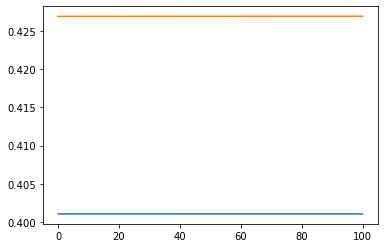

In [18]:
plt.plot(training_loss[200:])
plt.plot(validation_loss[200:])

##  <a name="9">9 Recommendations</a> 
(<a href="#0">Go to top</a>)

Let's finally have a look at our recommender system. That is, the last $P$ matrix from the gradient descent algorithm! Print it and have a look at its elements. All those empty entries of the $S$ matrix are now filled in with what are in fact recommendations for those users that have not yet rated those ASINs.

This means that now that we have a trained recommender model, we can find all user-ASIN pairs in the training set where the user has not rated an ASIN, and make a recommendation based on the entries of the prediction matrix for that particular user-ASIN pair. 


### Project Question 9

> Machine learning problems are often solved by carefully tuning and/or adding in more and more ingredients which slowly improve the model performance little by little. Improve model performance, then use the following code to extract the test predictions from the prediction matrix. Print out a sample of the test predictions, and have a look at the values. If all goes well, these should be values roughly between 1 and 5.

In [19]:
### Implement Code for Project Question 9 here ###
###################################################

import numpy as np

# This is just a sample predictions of all ones
# REPLACE WITH YOUR P matrix 

# Get predictions for the test_features set from the prediction matrix P 
test_predictions = []
for index, row in test_features.iterrows():
    userIdx = uniqueUsers.index(row['User'])
    ASINIdx = uniqueASINs.index(row['ASIN'])
    test_predictions.append(P[userIdx, ASINIdx])

# This is just a sample test predictions of all ones
# REPLACE WITH YOUR TEST PREDICTIONS
print(test_predictions[0:10])

[4.838333423132668, 4.193378310457612, 5.0, 4.787716579315998, 4.963415392439763, 4.58757562189902, 4.774057313939899, 5.0, 4.629601428003545, 4.3124033271222295]


In [20]:
np.unique(test_predictions)

array([1.85733172, 1.95921494, 1.9660451 , ..., 4.9999743 , 4.99999418,
       5.        ])

##  <a name="10">10 Submit to Leaderboard</a> 
(<a href="#0">Go to top</a>)

Although we can repeat Question 9 on the train and validation dataset, extracting the train and validation predictions from the prediction matrix and compare them against the real train and validaiton ratings (that we can extract from the ```train``` the ```val``` datasets), we would not be able to know how well the recommender system works on the test dataset unless we submit to the Leaderboard! 


### Project Question 10

> Use the following code to write the test predictions to a CSV file (in the format expected by the Leaderboard). Download locally the CSV file from the SageMaker instance folder, and upload it to [https://leaderboard.corp.amazon.com/tasks/665/submit](__https://leaderboard.corp.amazon.com/tasks/665/submit__). Good luck!


In [21]:
### Implement Code for Project Question 10 here ###
###################################################

import pandas as pd

# Get test predictions in the format expected by the Leaderboard
submission = pd.DataFrame(columns=["ID", "Rating"])
submission["ID"] = test_features["ID"]
submission["Rating"] = test_predictions 

submission.to_csv("regularized_gradient_descent_v_final.csv", index=False)

# This is just a sample test predictions of all ones
# REPLACE WITH YOUR TEST PREDICTIONS
print(submission.head())

      ID    Rating
0  84634  4.838333
1  55852  4.193378
2  28875  5.000000
3  94134  4.787717
4  31501  4.963415


In [23]:
submission['Rating'].value_counts(bins=5)

(4.371, 5.0]                   17916
(3.743, 4.371]                  7383
(3.114, 3.743]                  1598
(2.486, 3.114]                   236
(1.8530000000000002, 2.486]       25
Name: Rating, dtype: int64

<AxesSubplot:>

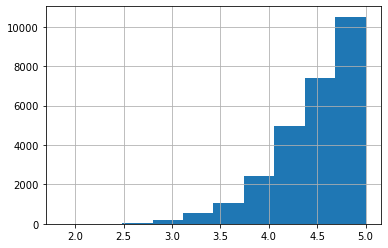

In [24]:
submission['Rating'].hist()

##  <a name="100">Final Comments</a> 
(<a href="#0">Go to top</a>)

Once you get your final metric and compare it to the original rating, you might find yourself disappointed that it wasn't too much better.  I will say that the $14\%$ improvement you should have seen is actually quite large.  This is the way of things in most ML projects. Something very near this algorithm is what gave Netflix its early lead in the movie recommendation market in the early 2000s.  They were only able to decrease the error by another $0.1$ stars after offering a [million dollar prize](https://en.wikipedia.org/wiki/Netflix_Prize) which took $3$ years of joint academic and industry effort to claim!  

You will often times be able to implement a trivial solution in minutes to do an ok job, work for weeks to improve on it by $10\%$, and then years to get another $10\%$.  Reading the [writeup](http://www.netflixprize.com/assets/ProgressPrize2008_BellKor.pdf) by the winning team will let you get a feeling of how subtle these gains often are!

## End of Notebook